In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import plot_model 
from keras import models
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
import csv 
import pandas as pd
import numpy as np
from numpy.random import seed

In [ ]:
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from datetime import timedelta
import time
import tensorflow as tf
import keras as keras
from keras.models import Sequential
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
#Download the data which are a drive
from google.colab import drive
drive.mount('/content/drive')
serie_inflation = pd.read_csv('/content/drive/My Drive/Copie de CPIAUCSL.csv')
#we create a data frame with only the datas we will use for the model 
serie_inflation["DATE"]=pd.to_datetime(serie_inflation["DATE"])
serie_inflation.set_index('DATE',inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Creating the Growth
serie_inflation["Growth"] = (serie_inflation - serie_inflation.shift()) / serie_inflation.shift()
serie_inflation = serie_inflation.drop(columns = ["CPIAUCSL"])
serie_inflation

,Growth
DATE,
1947-01-01,NaN
1947-02-01,0.006518
1947-03-01,0.017576
1947-04-01,0.000000
1947-05-01,-0.002273
...,...
2021-10-01,0.008665
2021-11-01,0.006992
2021-12-01,0.005752


In [ ]:
#Splitting data into test and train
splitting_date = 876
train_data , validation_data = serie_inflation[1:splitting_date] , serie_inflation[splitting_date:]

In [ ]:
#Computing mean and standard deviation of train data
mean_train = train_data.mean()
std_train = train_data.std()

#Normalizing the data
train_data = (train_data - mean_train)/std_train
validation_data = (validation_data - mean_train)/std_train
serie_inflation = (serie_inflation - mean_train)/std_train

train_data

,Growth
DATE,
1947-02-01,1.069369
1947-03-01,4.295440
1947-04-01,-0.832000
1947-05-01,-1.495010
1947-06-01,0.895752
...,...
2019-08-01,-0.513942
2019-09-01,-0.357140
2019-10-01,-0.025937


In [ ]:
#define X_train and y_train using lagged data, we are using the inflation on the past 6 years in order to try to forecast the following data
# Hence they will be 72 lagged time-steps and 1 output

X_train  = []
y_train = []
lagg = 72 
for i in range(lagg,splitting_date-1):
  X_train.append(train_data[i-lagg:i])
  y_train.append(train_data[i:i+1])
X_train , y_train = np.array(X_train) , np.array(y_train)
print(X_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(803, 72, 1)


(803, 72, 1)

In [ ]:
network = models.Sequential()

#Adding the first LSTM layer
network.add(LSTM(units = 100, activation = 'relu' ,  return_sequences = False, input_shape = (X_train.shape[1], 1)))
#Adding Classic layers
network.add(layers.Dense(50 , activation = 'relu'))
network.add(layers.Dense(50 , activation = 'relu'))
network.add(layers.Dense(15 , activation = 'relu'))
network.add(layers.Dense(15 , activation = 'relu'))
network.add(layers.Dense(15 , activation = 'relu'))
network.add(layers.Dense(15 , activation = 'relu'))

network.add(Dense(units = 1))

network.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error')

network.fit(X_train, y_train, epochs = 100)

Epoch 1/100
26/26 [==============================] - 3s 51ms/step - loss: 1294702187905024.0000
Epoch 2/100
26/26 [==============================] - 1s 49ms/step - loss: 78240384.0000
Epoch 3/100
26/26 [==============================] - 1s 49ms/step - loss: 0.7513
Epoch 4/100
26/26 [==============================] - 1s 51ms/step - loss: 0.5147
Epoch 5/100
26/26 [==============================] - 1s 51ms/step - loss: 0.4963
Epoch 6/100
26/26 [==============================] - 1s 50ms/step - loss: 0.4782
Epoch 7/100
26/26 [==============================] - 1s 50ms/step - loss: 0.4866
Epoch 8/100
26/26 [==============================] - 1s 49ms/step - loss: 0.4842
Epoch 9/100
26/26 [==============================] - 1s 50ms/step - loss: 0.4619
Epoch 10/100
26/26 [==============================] - 1s 52ms/step - loss: 0.4642
Epoch 11/100
26/26 [==============================] - 1s 50ms/step - loss: 0.4595
Epoch 12/100
26/26 [==============================] - 1s 51ms/step - loss: 0.4617
Epo

#Short Term Forecasting

In [ ]:
#Get the predicted values

inputs = serie_inflation[len(serie_inflation) - len(validation_data) - lagg:]
X_test = []
for i in range(lagg , len(inputs)):
  X_test.append(inputs[i-lagg:i])
X_test = np.array(X_test)  

predicted_inflation = network.predict(X_test)

In [ ]:
predicted_inflation

array([[-0.23866718],
       [-0.24584986],
       [-0.2577267 ],
       [-1.0582744 ],
       [-1.5366699 ],
       [-0.04248951],
       [-0.10550354],
       [-0.1298994 ],
       [-0.11517435],
       [-0.07128301],
       [-0.07859704],
       [-0.06080241],
       [-0.09290068],
       [-0.12080652],
       [-0.03433991],
       [ 0.11955153],
       [ 0.26977783],
       [ 0.42015195],
       [ 0.55066526],
       [ 0.46664405],
       [ 0.41313946],
       [ 0.4267392 ],
       [ 0.6876145 ],
       [ 0.7138304 ],
       [ 0.6887052 ],
       [ 0.7305621 ]], dtype=float32)

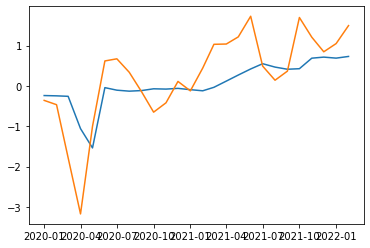

In [ ]:
plt.plot(validation_data.index , predicted_inflation)
plt.plot(validation_data)

In [ ]:
#Return to unnormalize prediction with the normalize one
forecasting_inflation = pd.DataFrame(index = validation_data.index , data = {
    "Normalize Forecasting": predicted_inflation.tolist(),
    "Forecasting": (predicted_inflation * std_train.values[0] + mean_train.values[0]).tolist()
}) 

for i in range(len(forecasting_inflation)):
  forecasting_inflation["Forecasting"][i] = np.array(forecasting_inflation["Forecasting"][i])[0]
  forecasting_inflation["Normalize Forecasting"][i] = np.array(forecasting_inflation["Normalize Forecasting"][i])[0]

forecasting_inflation

,Normalize Forecasting,Forecasting
DATE,,
2020-01-01,-0.238667,0.002034
2020-02-01,-0.24585,0.002009
2020-03-01,-0.257727,0.001969
2020-04-01,-1.058274,-0.000776
2020-05-01,-1.53667,-0.002416
2020-06-01,-0.04249,0.002706
2020-07-01,-0.105504,0.00249
2020-08-01,-0.129899,0.002407
2020-09-01,-0.115174,0.002457


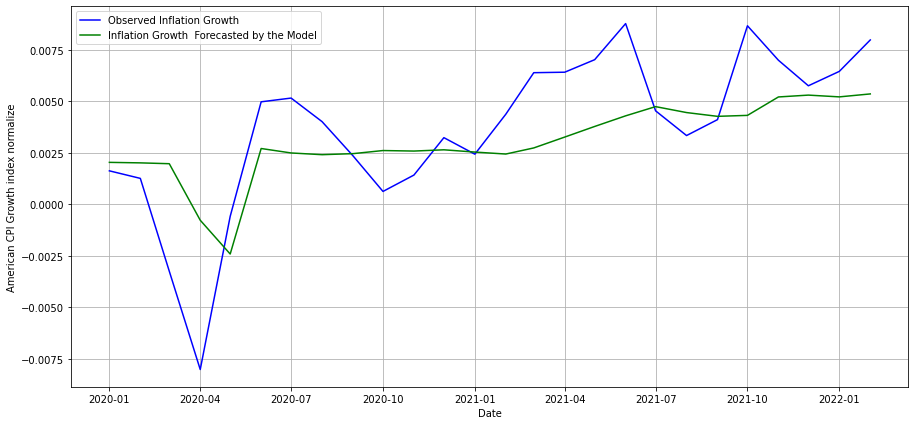

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(validation_data *std_train.values[0] + mean_train.values[0]  , color = "blue" , label= "Observed Inflation Growth")
plt.plot(forecasting_inflation["Forecasting"] , color = "green" , label = "Inflation Growth  Forecasted by the Model")
plt.ylabel("American CPI Growth index normalize")
plt.xlabel("Date")
plt.legend()
plt.grid()

In [ ]:
serie_inflation_2 = pd.read_csv('/content/drive/My Drive/Copie de CPIAUCSL.csv')
serie_inflation_2["DATE"]=pd.to_datetime(serie_inflation_2["DATE"])
serie_inflation_2.set_index('DATE',inplace=True)


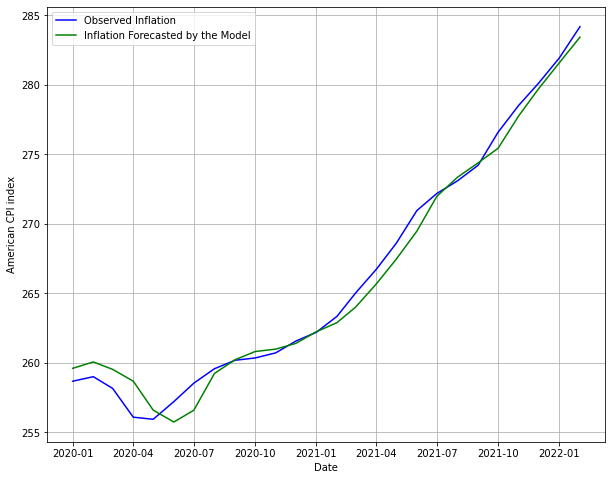

In [ ]:
#Reconstruct the index from the index growth
Inflation_Forcasted = []
for i in range(splitting_date-1 , len(serie_inflation)-1):
  Inflation_Forcasted.append(serie_inflation_2["CPIAUCSL"][i] * forecasting_inflation["Forecasting"][i - splitting_date -1 ] + serie_inflation_2["CPIAUCSL"][i])
Inflation_Forcasted = np.array(Inflation_Forcasted)
#Recall that P_{t+1} = P_t (1 + R_{t+1}) because it is monthly growth here

#Plot the forecasting index
plt.figure(figsize=(10,8))
plt.plot(serie_inflation_2[splitting_date :]  , color = "blue" , label= "Observed Inflation")
plt.plot(validation_data.index , Inflation_Forcasted , color = "green" , label = "Inflation Forecasted by the Model")
plt.ylabel("American CPI index")
plt.xlabel("Date")
plt.legend()
plt.grid()

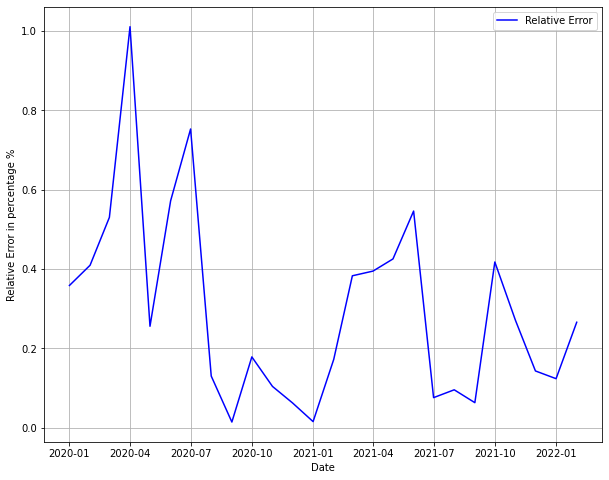

In [ ]:
#Relative Error
Relative_Error = np.abs(Inflation_Forcasted - (serie_inflation_2["CPIAUCSL"][splitting_date:])) / (serie_inflation_2["CPIAUCSL"][splitting_date:])
plt.figure(figsize=(10,8))
plt.plot(validation_data.index , Relative_Error * 100 , color = "blue" , label = "Relative Error")
plt.ylabel("Relative Error in percentage %")
plt.xlabel("Date")
plt.legend()
plt.grid()

# Long Term Forecasting

In [ ]:
## Forecast values using the forecast values
## Creation the input for the each simulation

inputs = serie_inflation[len(serie_inflation) - len(validation_data) - lagg:]
dynamics_prediction = []
for i in range(len(validation_data)):
  X_test = []
  X_test.append(inputs[i:i+lagg])
  X_test = np.array(X_test)
  prediction = network.predict(X_test) #computing prediction
 
  inputs[i+lagg:i+1+lagg]["Growth"].values[0] = prediction[0][0] #Change the known value of inflation by the predicted one
  dynamics_prediction.append(prediction[0][0])
  
display(dynamics_prediction)

-1.780360255957286

-0.23797588050365448

[-0.23866718,
 -0.23809321,
 -0.23797588,
 -0.2377754,
 -0.23738189,
 -0.23719077,
 -0.23704533,
 -0.23676367,
 -0.23637547,
 -0.23589431,
 -0.23535456,
 -0.23480515,
 -0.23426466,
 -0.23374651,
 -0.2332607,
 -0.23281275,
 -0.23240553,
 -0.23203976,
 -0.23171444,
 -0.2314273,
 -0.23117553,
 -0.23095651,
 -0.23076649,
 -0.23060222,
 -0.23046033,
 -0.23033823]

In [ ]:
#constructing the unnormalize index
dynamics_forecasting_inflation = pd.DataFrame(index = validation_data.index , data = {
    "Normalize Forecasting": dynamics_prediction,
    "Forecasting": (np.array(dynamics_prediction) * std_train.values[0] + mean_train.values[0]).tolist()
})
dynamics_forecasting_inflation

,Normalize Forecasting,Forecasting
DATE,,
2020-01-01,-0.238667,0.002034
2020-02-01,-0.238093,0.002036
2020-03-01,-0.237976,0.002036
2020-04-01,-0.237775,0.002037
2020-05-01,-0.237382,0.002038
2020-06-01,-0.237191,0.002039
2020-07-01,-0.237045,0.002039
2020-08-01,-0.236764,0.002040
2020-09-01,-0.236375,0.002042


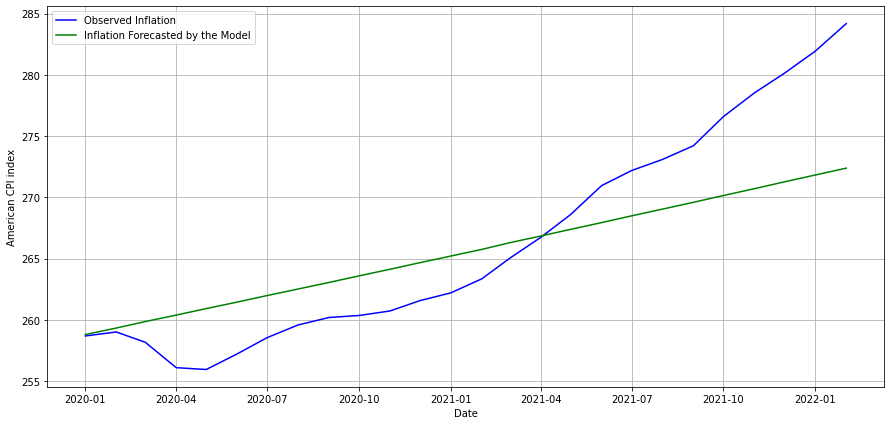

In [ ]:
#Reconstruct the index from the index growth
Inflation_Forcasted = []
for i in range(splitting_date-1 , len(serie_inflation)-1):
  if i == splitting_date-1:
    Inflation_Forcasted.append(serie_inflation_2["CPIAUCSL"][i] * dynamics_forecasting_inflation["Forecasting"][i - splitting_date -1 ] + serie_inflation_2["CPIAUCSL"][i])
  else:
    Inflation_Forcasted.append(Inflation_Forcasted[i-splitting_date] * dynamics_forecasting_inflation["Forecasting"][i - splitting_date -1 ] + Inflation_Forcasted[i-splitting_date])
Inflation_Forcasted = np.array(Inflation_Forcasted)

#Plot the forecast of the CPI index
plt.figure(figsize=(15,7))
plt.plot(serie_inflation_2[splitting_date :]  , color = "blue" , label= "Observed Inflation")
plt.plot(validation_data.index , Inflation_Forcasted , color = "green" , label = "Inflation Forecasted by the Model")
plt.ylabel("American CPI index")
plt.xlabel("Date")
plt.legend()
plt.grid()